Initial observation: [0.3450376  0.93858886 0.28291646]
Episode ended at step 199

Results:
Total steps: 200
Total reward: -382.651
Average reward per step: -1.913
Action range: [-5.066, 3.066]


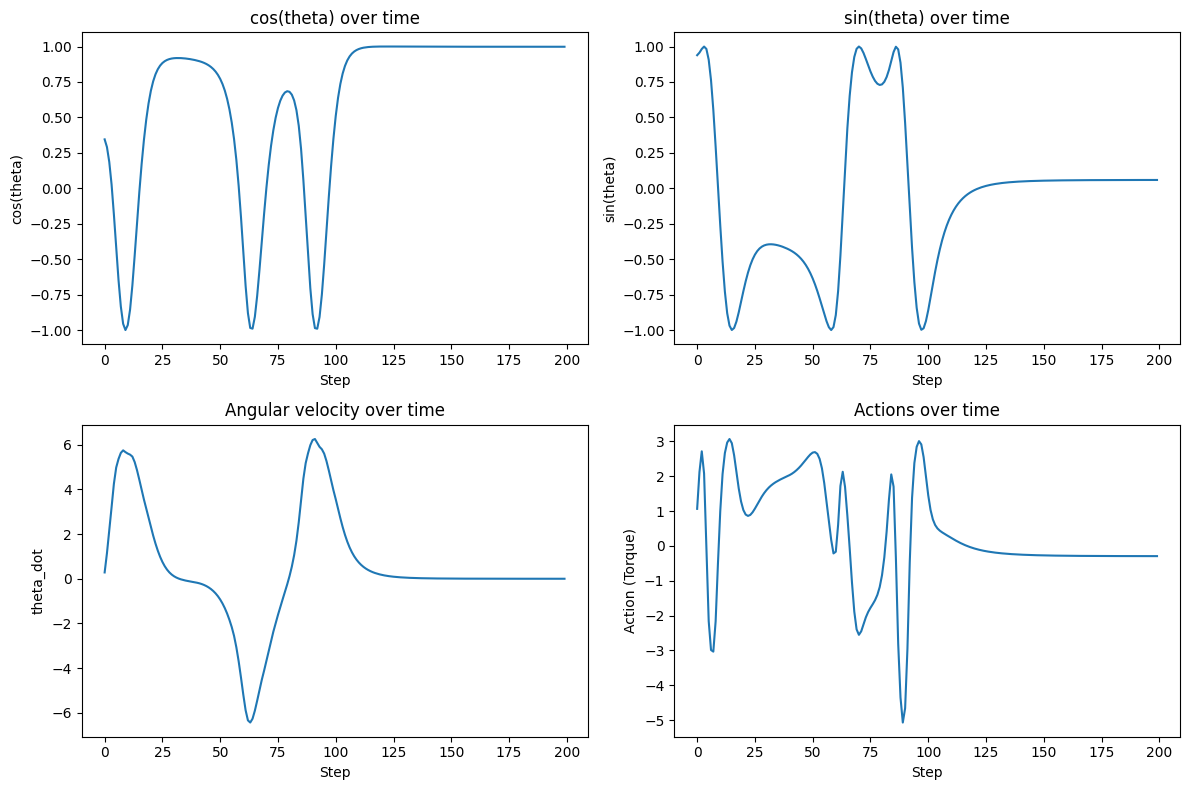

In [8]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error

# user_input = "- (0.438 * x * x1) + (0.078 * x1 * x2) + (0.031 * x2^2) - (0.375 * x^2 * x1) + (0.625 * x * x1 * x2) + (0.156 * x * x2^2) + (1.125 * x1^3) + (1.062 * x1^2 * x2) - (0.156 * x1 * x2^2) - (0.047 * x2^3) - (0.031 * x^4) - (3.000 * x^3 * x1) - (1.125 * x^3 * x2) + (0.047 * x^2 * x1^2) + (0.750 * x^2 * x1 * x2) + (0.188 * x^2 * x2^2) + (0.062 * x * x1^2 * x2) - (0.125 * x * x1 * x2^2) - (0.047 * x * x2^3) - (0.031 * x1^4) + (0.094 * x^5) - (2.250 * x^4 * x1) - (0.188 * x^4 * x2) - (0.625 * x^3 * x1^2) + (0.141 * x^3 * x1 * x2) + (0.062 * x^3 * x2^2) - (0.078 * x^2 * x1 * x2^2) - (0.031 * x^2 * x2^3) + (0.500 * x * x1^4) + (0.016 * x * x1 * x2^3) + (0.016 * x1^5) + (0.031 * x1^4 * x2)"
user_input = "- (0.438 * x * y) + (0.078 * y * z) + (0.031 * z^2) - (0.375 * x^2 * y) + (0.625 * x * y * z) + (0.156 * x * z^2) + (1.125 * y^3) + (1.062 * y^2 * z) - (0.156 * y * z^2) - (0.047 * z^3) - (0.031 * x^4) - (3.000 * x^3 * y) - (1.125 * x^3 * z) + (0.047 * x^2 * y^2) + (0.750 * x^2 * y * z) + (0.188 * x^2 * z^2) + (0.062 * x * y^2 * z) - (0.125 * x * y * z^2) - (0.047 * x * z^3) - (0.031 * y^4) + (0.094 * x^5) - (2.250 * x^4 * y) - (0.188 * x^4 * z) - (0.625 * x^3 * y^2) + (0.141 * x^3 * y * z) + (0.062 * x^3 * z^2) - (0.078 * x^2 * y * z^2) - (0.031 * x^2 * z^3) + (0.500 * x * y^4) + (0.016 * x * y * z^3) + (0.016 * y^5) + (0.031 * y^4 * z)"

# Factorised
# user_input = "z^2.0 * (-(0.047 * z) + 0.031 - 0.156 * y + x * (0.156 - 0.047 * z + x * (0.188 + 0.062 * x - 0.031 * z))) + x^3.0 * (-(1.125 * z) + x * (-0.031 + 0.094 * x - 0.188 * z)) + y * (0.078 * z + (-0.438 + 0.5 * y^3.0 + x * (-0.375 + 0.047 * y + x * (-3.0 - 2.25 * x - 0.625 * y + 0.141 * z) + z * (0.75 - 0.078 * z)) + z * (0.625 + 0.062 * y + z * (-0.125 + 0.016 * z))) * x + y * (1.062 * z + (1.125 + y * (-0.031 + 0.016 * y + 0.031 * z)) * y))"

def create_policy_function(equation_str):
    def policy_fn(obs, model=None):

        # Extract state variables from observation
        # For Pendulum-v1: obs = [cos(theta), sin(theta), theta_dot]
        x = obs[0]  # cos(theta)
        y = obs[1]  # sin(theta) 
        z = obs[2]  # theta_dot
        
        equation = equation_str.replace('^', '**')
        # Create x namespace dictionary with the state variables
        namespace = {'x': x, 'y': y, 'z': z}
        
        # Evaluate the equation with current state values
        action = eval(equation, {"__builtins__": {}}, namespace)
        
        # Ensure action is x scalar and within reasonable bounds
        if type(action) == np.ndarray:
            action = action.item()
        
        # Clip action to reasonable range
        action = np.clip(action, -10.0, 10.0)
        
        return action
            
      
    return policy_fn

def run_policy(env_id, policy_fn, seed, model=None, max_steps=500, dt=0.001, render=False):
    env = gym.make(env_id, render_mode="human" if render else None)
    obs, _ = env.reset(seed= seed)
    print("Initial observation:", obs)
    
    obs_list, action_list = [], []
    total_reward = 0

    for step in range(max_steps):
        # Gets the action from policy function
        action = policy_fn(obs, model)
        
        # Handle different action space types
        if type(env.action_space) == gym.spaces.Discrete:
            action_env = int(np.round(np.clip(action, 0, env.action_space.n - 1)))
        else:
            # For continuous action spaces (like Pendulum)
            action_env = np.array([action], dtype=np.float32)
            action_env = np.clip(action_env, env.action_space.low, env.action_space.high)

        obs_list.append(obs.copy())
        action_list.append(action)

        obs, reward, terminated, truncated, _ = env.step(action_env)
        total_reward += reward

        if render:
            time.sleep(dt)
            
        if terminated or truncated:
            print(f"Episode ended at step {step}")
            break

    env.close()
    return np.array(obs_list), np.array(action_list), total_reward

# Create the policy function from the user input
policy_function = create_policy_function(user_input)



    
# Run the policy
observations, actions, total_reward = run_policy(
    env_id="Pendulum-v1",
    policy_fn=policy_function,
    seed = 23,
    model=None,
    max_steps=500,
    dt=0.05,  
    render=True )

print(f"\nResults:")
print(f"Total steps: {len(observations)}")
print(f"Total reward: {total_reward:.3f}")
print(f"Average reward per step: {total_reward/len(observations):.3f}")
print(f"Action range: [{actions.min():.3f}, {actions.max():.3f}]")

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(observations[:, 0])
plt.title('cos(theta) over time')
plt.xlabel('Step')
plt.ylabel('cos(theta)')

plt.subplot(2, 2, 2)
plt.plot(observations[:, 1])
plt.title('sin(theta) over time')
plt.xlabel('Step')
plt.ylabel('sin(theta)')

plt.subplot(2, 2, 3)
plt.plot(observations[:, 2])
plt.title('Angular velocity over time')
plt.xlabel('Step')
plt.ylabel('theta_dot')

plt.subplot(2, 2, 4)
plt.plot(actions)
plt.title('Actions over time')
plt.xlabel('Step')
plt.ylabel('Action (Torque)')

plt.tight_layout()
plt.show()

91
Initial observation: [ 0.20637327 -0.97847337  0.8205019 ]
Episode ended at step 199
274
Initial observation: [-0.98874575  0.14960575 -0.543129  ]
Episode ended at step 199
117
Initial observation: [-0.70715904  0.70705456 -0.684238  ]
Episode ended at step 199
182
Initial observation: [-0.5037465  -0.8638515  -0.36307347]
Episode ended at step 199
124
Initial observation: [-0.21969503  0.9755686   0.5717187 ]
Episode ended at step 199
281
Initial observation: [ 0.93917763 -0.34343177  0.81336194]
Episode ended at step 199
70
Initial observation: [ 0.7321215  -0.68117404  0.4476117 ]
Episode ended at step 199
176
Initial observation: [-0.8402522  0.5421957 -0.7038375]
Episode ended at step 199
215
Initial observation: [-0.84754014  0.5307313  -0.9081097 ]
Episode ended at step 199
12
Initial observation: [ 0.0051802 -0.9999866  0.8935059]
Episode ended at step 199


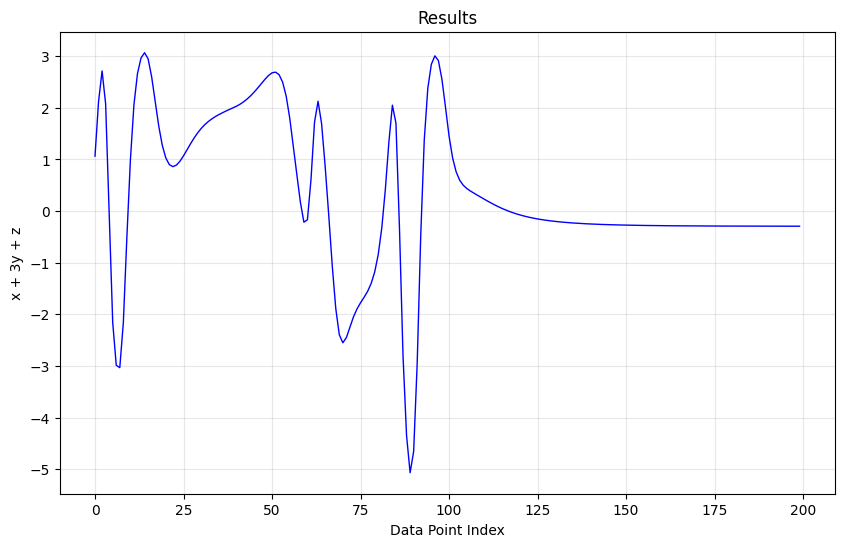

In [32]:
from QuantisationDetermination import calculate_with_dfg
import random

variables = {
    'x': observations[:, 0],
    'y': observations[:, 1], 
    'z': observations[:, 2]
}

# Fully expanded form - pendulum
user_input = "- (0.438 * x * y) + (0.078 * y * z) + (0.031 * z^2) - (0.375 * x^2 * y) + (0.625 * x * y * z) + (0.156 * x * z^2) + (1.125 * y^3) + (1.062 * y^2 * z) - (0.156 * y * z^2) - (0.047 * z^3) - (0.031 * x^4) - (3.000 * x^3 * y) - (1.125 * x^3 * z) + (0.047 * x^2 * y^2) + (0.750 * x^2 * y * z) + (0.188 * x^2 * z^2) + (0.062 * x * y^2 * z) - (0.125 * x * y * z^2) - (0.047 * x * z^3) - (0.031 * y^4) + (0.094 * x^5) - (2.250 * x^4 * y) - (0.188 * x^4 * z) - (0.625 * x^3 * y^2) + (0.141 * x^3 * y * z) + (0.062 * x^3 * z^2) - (0.078 * x^2 * y * z^2) - (0.031 * x^2 * z^3) + (0.500 * x * y^4) + (0.016 * x * y * z^3) + (0.016 * y^5) + (0.031 * y^4 * z)"
user_input = user_input.replace('^', '**')

original_expression = eval(user_input, {"__builtins__": {}}, variables)


## Factorized expression
factorized_input = "z^2.0 * (-(0.047 * z) + 0.031 - 0.156 * y + x * (0.156 - 0.047 * z + x * (0.188 + 0.062 * x - 0.031 * z))) + x^3.0 * (-(1.125 * z) + x * (-0.031 + 0.094 * x - 0.188 * z)) + y * (0.078 * z + (-0.438 + 0.5 * y^3.0 + x * (-0.375 + 0.047 * y + x * (-3.0 - 2.25 * x - 0.625 * y + 0.141 * z) + z * (0.75 - 0.078 * z)) + z * (0.625 + 0.062 * y + z * (-0.125 + 0.016 * z))) * x + y * (1.062 * z + (1.125 + y * (-0.031 + 0.016 * y + 0.031 * z)) * y))"


quant = False
m = 7
n = 11
# B port shifts cannot be larger than n or 7
b_port_shifts = 0


random_seeds = [random.randrange(3, 301) for _ in range(10)]

dfg_dict = {}
calc_dict = {}

for k in random_seeds:
    print(k)

    observations, actions, total_reward = run_policy(
        env_id="Pendulum-v1",
        policy_fn=policy_function,
        seed = k,
        model=None,
        max_steps=500,
        dt=0.05,  
        render=False)

    dfg_values = []
    calculated_values = []
    for j in range(0, observations.shape[0]):
        value_mapping = {'x': observations[j, 0], 'y': observations[j, 1], 'z': observations[j, 2]}



        dfg_val, val = calculate_with_dfg(factorized_input, value_mapping, quant, m, n, b_port_shifts, show_graph = False)

        dfg_values.append(dfg_val)
        calculated_values.append(val)
    
    dfg_dict[k] = dfg_values
    calc_dict[k] = calculated_values



# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(original_expression, 'b-', linewidth=1)
plt.xlabel('Data Point Index')
plt.ylabel('x + 3y + z')
plt.title('Results')
plt.grid(True, alpha=0.3)
plt.show()


IndexError: index 3 is out of bounds for axis 0 with size 3

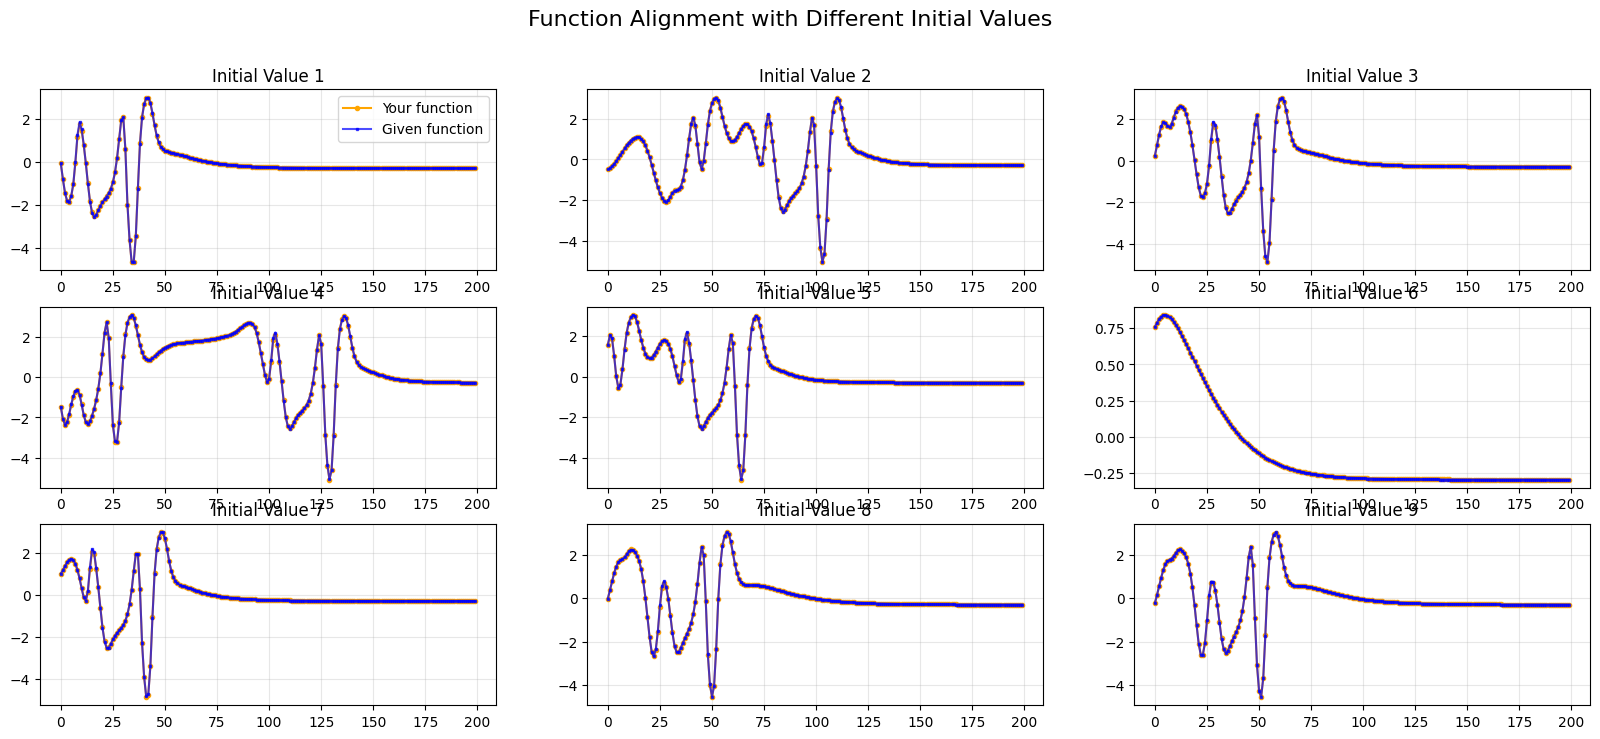

In [37]:

# plt.figure(figsize=(12, 8))

# for item, value in dfg_dict.items():

#     plt.plot(calc_dict[item], 's-', linewidth=1)
#     plt.plot(value, 'p--', label='Line 1', linewidth=2)


fig, axes = plt.subplots(3, 3, figsize=(20, 8))
fig.suptitle('Function Alignment with Different Initial Values', fontsize=16)

i = 0
for item, value in dfg_dict.items():
    
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    
    
    ax.plot(calc_dict[item], 'o-', color='orange', markersize=3, label='Your function')
    ax.plot(value, 's-', color='blue', markersize=2, alpha=0.7, label='Given function')
    
    ax.set_title(f'Initial Value {i+1}')
    ax.grid(True, alpha=0.3)
    
    if i == 0:  # Only add legend to first subplot
        ax.legend()
    
    i += 1

AttributeError: 'dict' object has no attribute 'shape'